In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import cmasher as cmr
import seaborn as sns

In [63]:
import os
import glob

#/Volumes/Lexar/20241003_fluorescence/3barBP/jet30ms/62msdel
try:
    common_folder_path = r"/Volumes/Lexar/20241003_fluorescence"
    bg_shotlist = glob.glob(common_folder_path + "/" + r"bg/*" + 'tif' + r"*")
    if len(bg_shotlist) == 0:
        raise FileNotFoundError("Path not found!")
except FileNotFoundError:
    print("Path not found!")  

print(bg_shotlist)
    

pressures = [22,24,26,29,32,35,38,40,44,47,50,53,57,60,63,68,70]    
print(f"Pressures: {pressures}")

Path not found!
[]
Pressures: [22, 24, 26, 29, 32, 35, 38, 40, 44, 47, 50, 53, 57, 60, 63, 68, 70]


[117.26916667   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
[117.26916667  79.7525       0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
[117.26916667  79.7525     511.95416667   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
[117.26916667  79.7525     511.95416667 657.57555556   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
[117.26916667  79.7525     511.95416667 657.57555556 506.05361111
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.     

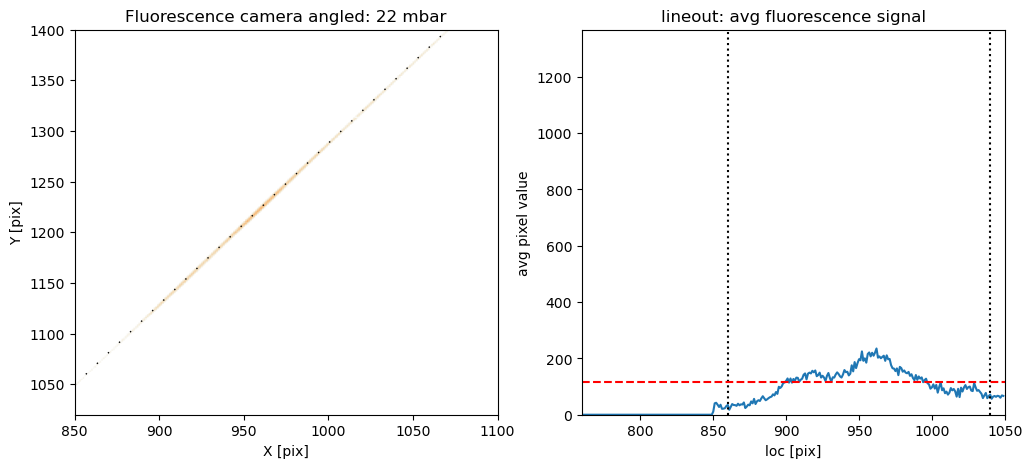

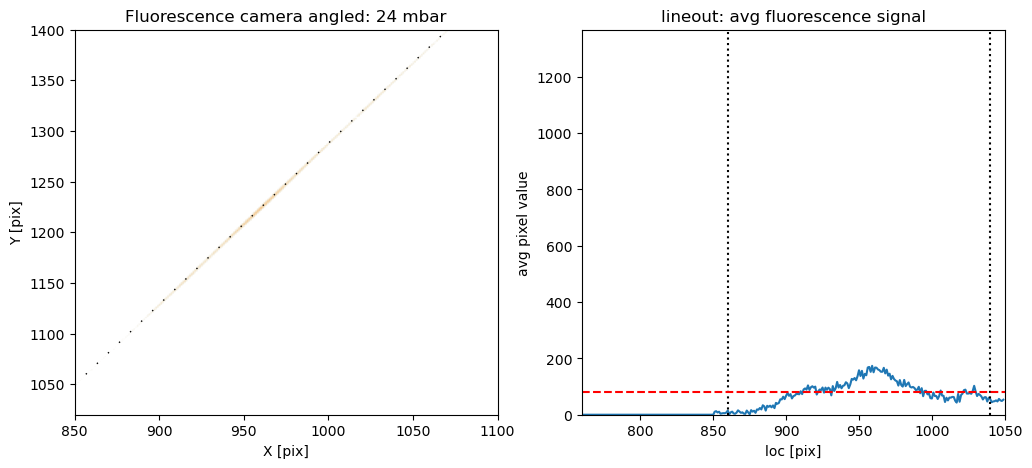

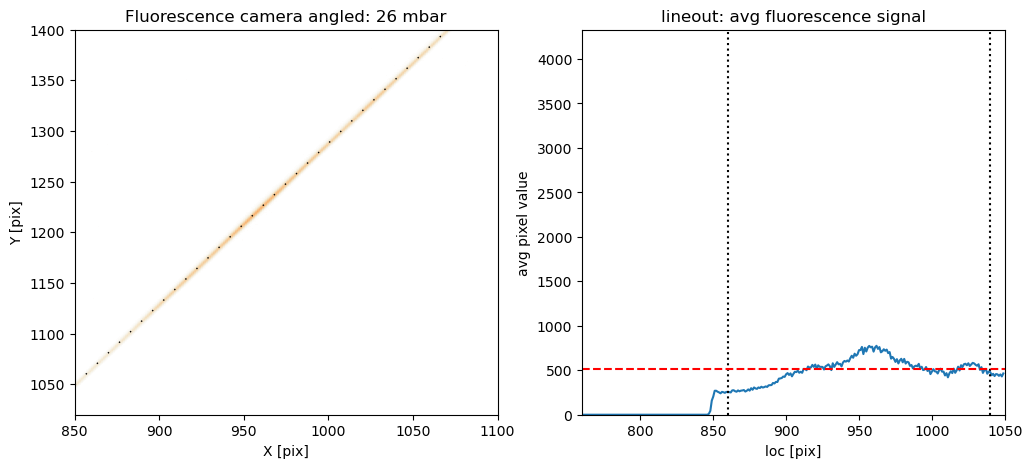

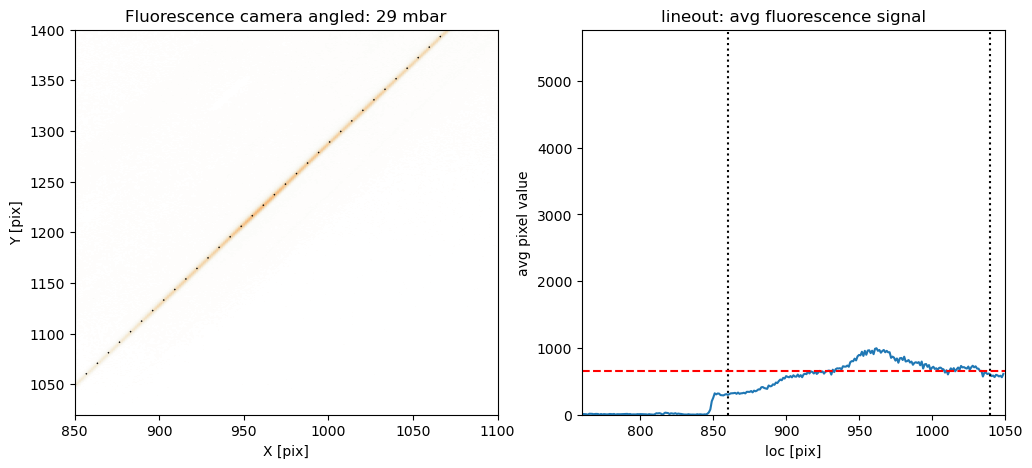

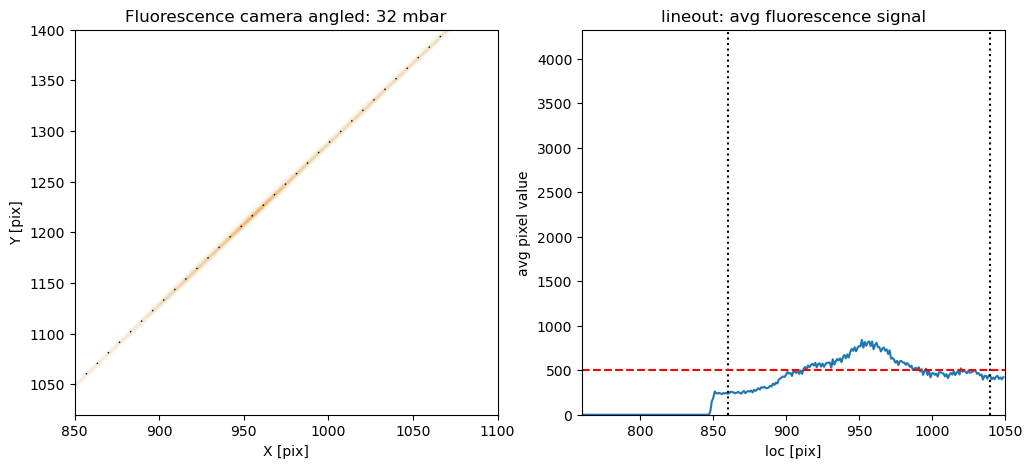

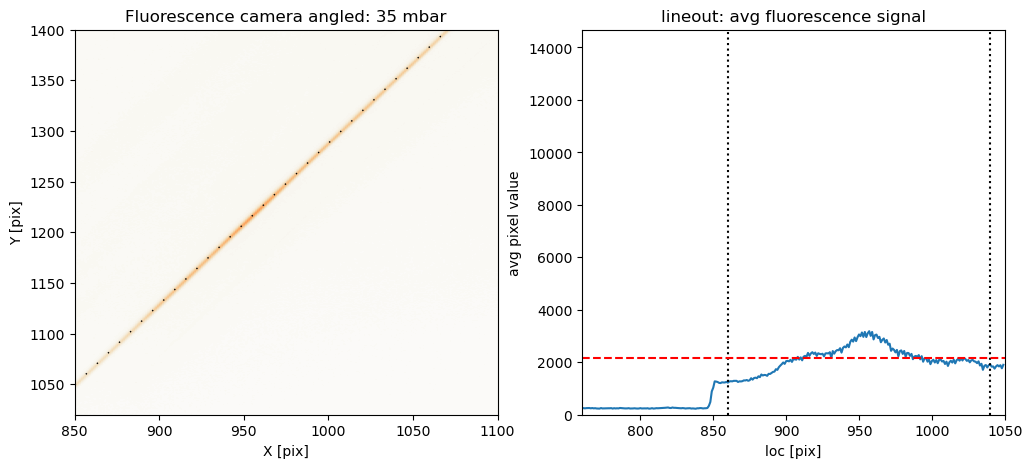

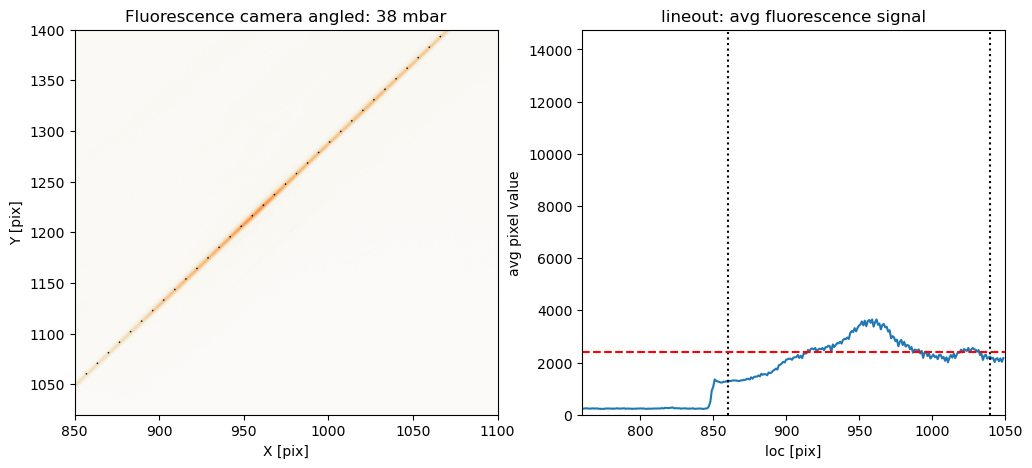

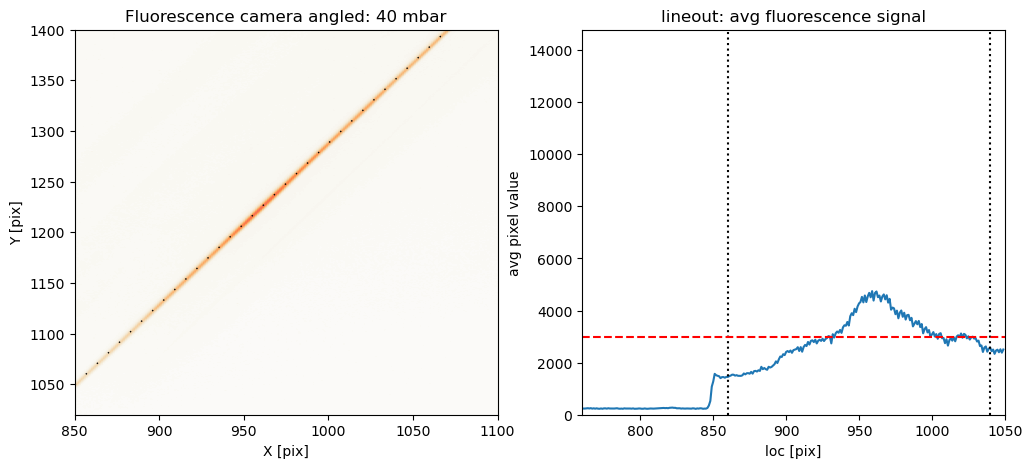

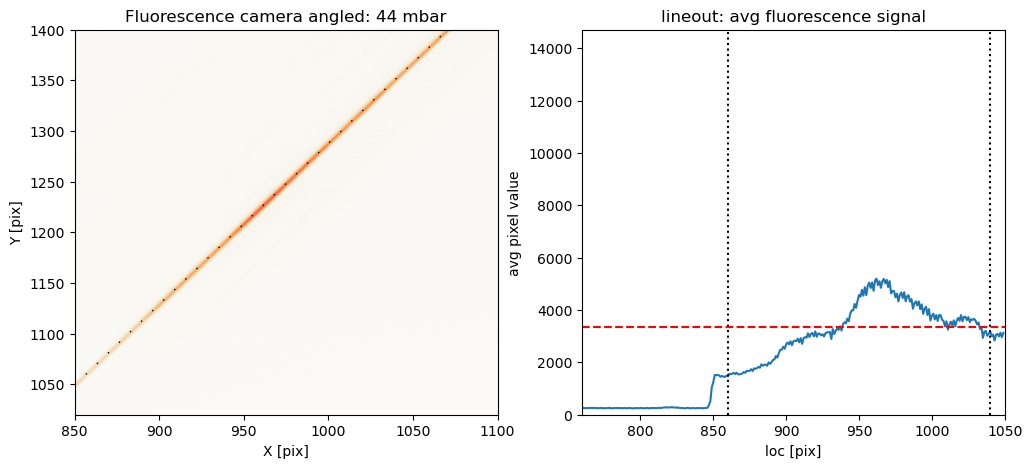

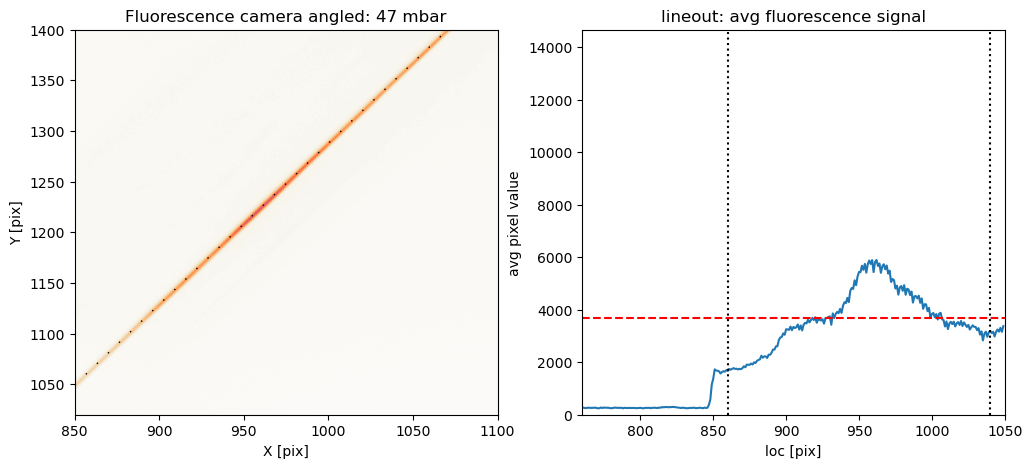

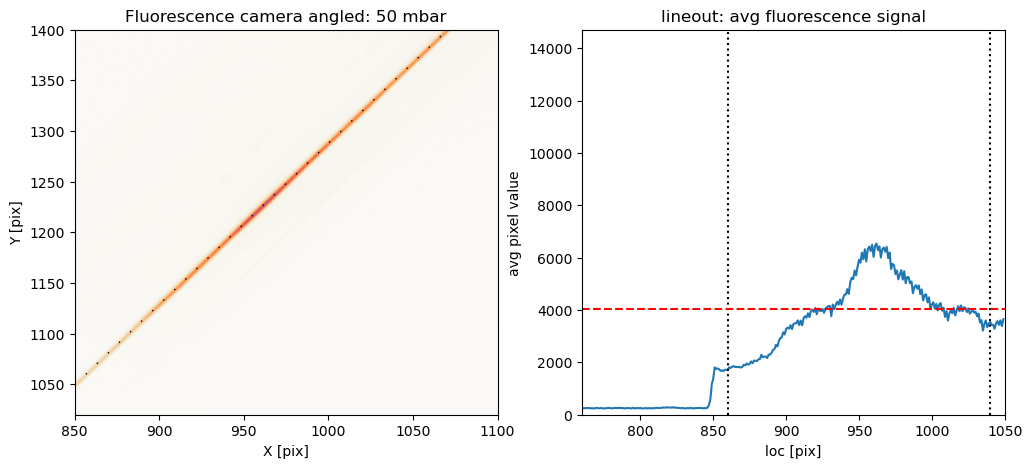

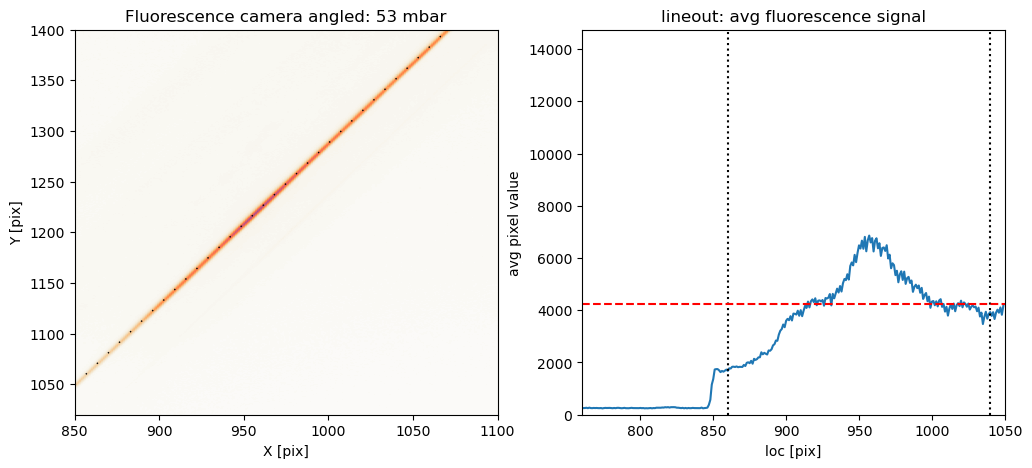

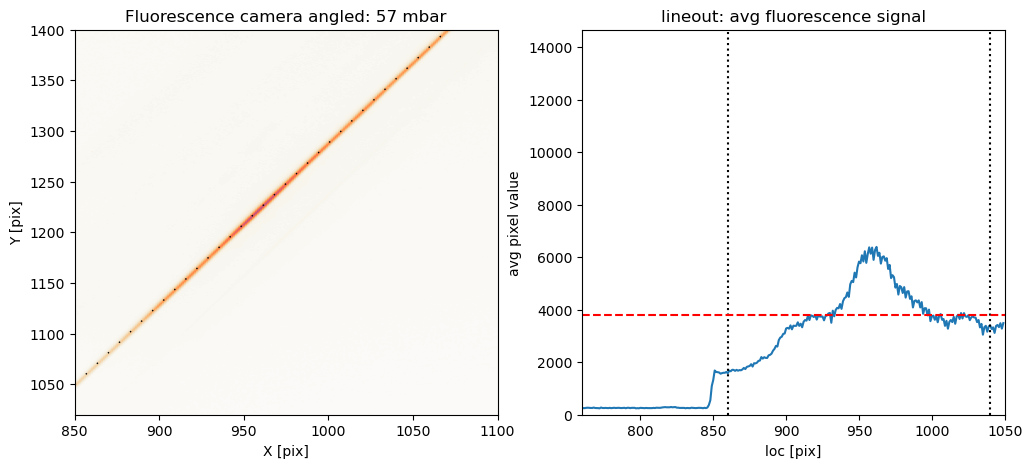

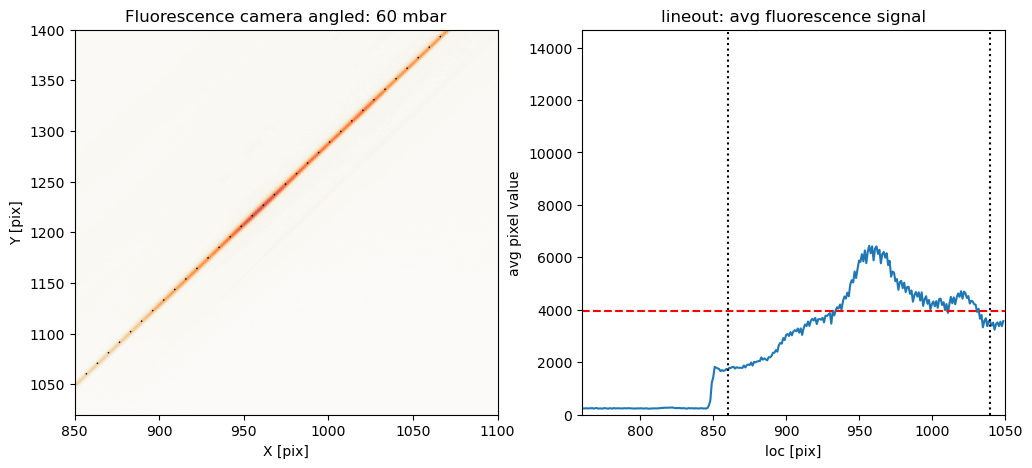

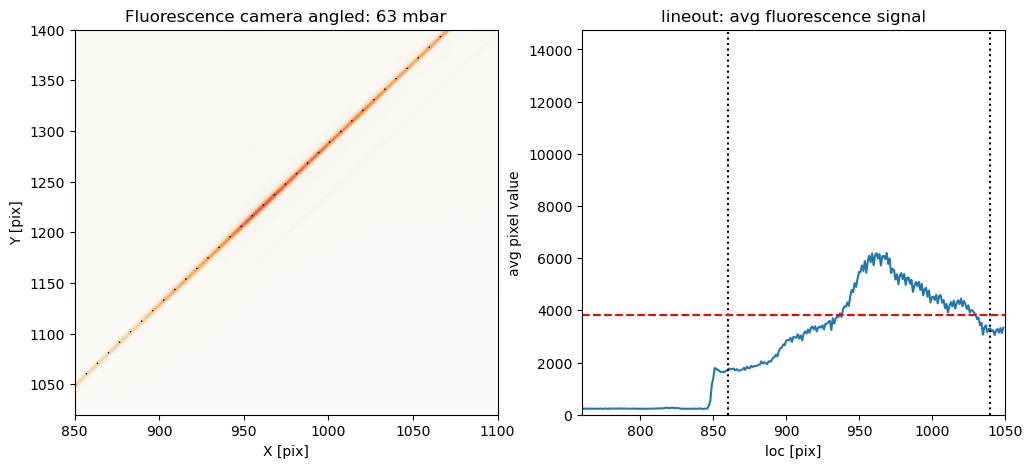

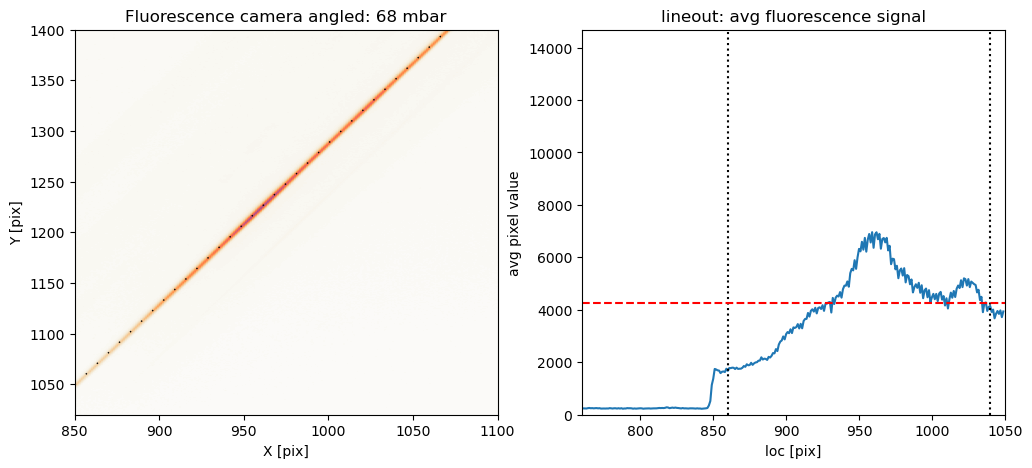

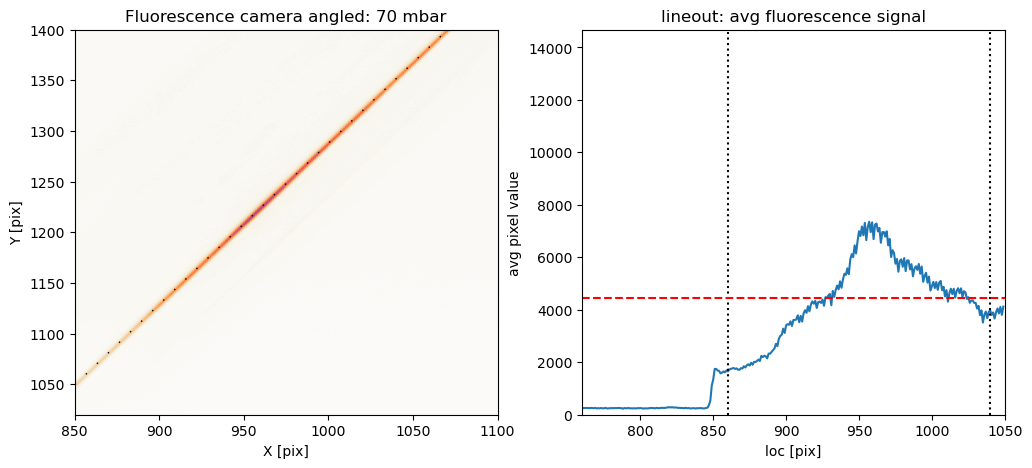

In [52]:
avg_sigs = np.zeros(len(pressures))

#avg_sigs_fri = np.zeros(len(pressures))

def load_and_calculate_average(filenames):
    # Initialize an empty array to store pixel values
    total_sum = None
    # Iterate over each filename
    for filename in filenames:
        # Load the image
        image = cv2.imread(filename, -1)
        # If this is the first image, initialize total_sum with zeros
        if total_sum is None:
            total_sum = np.zeros_like(image, dtype=np.uint64)
        # Add the pixel values of the current image to the total_sum
        total_sum += image.astype(np.uint64)
    # Calculate the average pixel value
    if total_sum is None:
        return None
    else:
        average_image = total_sum / len(filenames)
        average_image.astype(image.dtype)
        
    return average_image

def get_avg_signal_horizontal(shotlist, bg_shotlist, plot_flag, title):
    if len(shotlist) == 0:
        return 0
    else:
        average_image = load_and_calculate_average(shotlist)
        print(average_image[0])
        average_image_bg = load_and_calculate_average(bg_shotlist)
        print(average_image_bg[0])

        im = average_image - average_image_bg 
        im[im<0] = 0

        lineoutIdx = 735
        start = 540
        stop = 590
        d = 3
        lineout = np.mean(im[lineoutIdx-d:lineoutIdx+d,:], axis=0)
        avg_sig = np.mean(lineout[start:stop])

        if plot_flag:
            fig, axs = plt.subplots(1,2, figsize=(10,3))
            axs[0].imshow(im, aspect='auto', origin='lower', vmin=0, vmax=2**12, cmap=cmr.torch_r)
            axs[0].axhline(lineoutIdx, ls=':', color=[0.5,0.5,0.5,0.5])
            axs[0].set_xlim(200, 800)
            axs[0].set_ylim(730, 770)
            axs[0].set_xlabel('X [pix]')
            axs[0].set_ylabel('Y [pix]')

            axs[1].plot(lineout)
            axs[1].set_xlim(250, 650)
            
            axs[1].axvline(start,ls='dotted',color='black')
            axs[1].axvline(stop,ls='dotted',color='black')
            axs[1].set_title('lineout: avg fluorescence signal')
            axs[1].set_xlabel('loc [pix]')
            axs[1].set_ylabel('avg pixel value')


            axs[1].axhline(avg_sig,color='red',ls='dashed')
            axs[0].set_title('Fluorescence camera: '+title)
        return avg_sig

def get_avg_signal_angled(shotlist: list[str], 
                          bg_shotlist: list[str],
                          plot_flag: bool,
                          title: str,
                          max_pixel_value: int or str = 2**12,
                          line_grad: float =1.59,
                          line_intercept: float = -302,
                          line_start_x: int = 760,
                          line_stop_x: int = 1050,
                          average_start_x: int = 800,
                          average_stop_x: int = 1040, 
                          number_of_line_averages: int = 1):
    if len(shotlist) == 0:
        return 0
    else:
        average_image = load_and_calculate_average(shotlist)
        average_image_bg = load_and_calculate_average(bg_shotlist)
        if average_image_bg is None:
            print("No background images found, running without background removal...")
            im = average_image
        else:
            im = average_image - average_image_bg 
            
        im[im<0] = 0
        x_min, x_max = 0, len(im[0])
        y_min, y_max = 0, len(im)
                
        x_min_zoom, x_max_zoom = 850, 1100  ## Zoom section of the window
        y_min_zoom, y_max_zoom = 1020, 1400  ## Zoom section of the window
        
        if str(max_pixel_value) == "auto":
            max_pixel_value = np.max(im)
        
        lneqn = lambda x, m, c: m*x + c     ## Line section for following the plasma channel        
        lineoutlist = []
        for i in range(-number_of_line_averages, number_of_line_averages, 1):
            spectra = []         
            for j in range(line_start_x, line_stop_x, 1):
                y = round(lneqn(j, line_grad, line_intercept+i))
                if y > y_max:
                    y = y_max
                elif y < 0: 
                    y = 0
                
                val = im[y][j]
                spectra.append(val)
            lineoutlist.append(spectra)
            
        lineoutselect = np.mean(lineoutlist, axis=0)
        lineout = np.zeros((line_stop_x), dtype=lineoutselect.dtype)
        lineout[len(lineout)-len(lineoutselect):] = lineoutselect
        avg_sig = np.mean(lineout[average_start_x:average_stop_x])

        if plot_flag:
            fig, axs = plt.subplots(1,2, figsize=(12,5))
            axs[0].imshow(im, aspect='auto', origin='lower', vmin=0, vmax=max_pixel_value, cmap=cmr.torch_r)            
            axs[0].set_xlim(x_min_zoom, x_max_zoom)
            axs[0].set_ylim(y_min_zoom, y_max_zoom)
            x_vals = np.array(axs[0].get_xlim())
            y_vals = lneqn(x_vals, line_grad, line_intercept)
            axs[0].plot(x_vals, y_vals, linewidth=1, color='black', linestyle=(0, (1, 10)))
            axs[0].set_xlabel('X [pix]')
            axs[0].set_ylabel('Y [pix]')

            axs[1].plot(lineout)
            axs[1].set_xlim(line_start_x, line_stop_x)
            axs[1].set_ylim(0, max_pixel_value)
            
            axs[1].axvline(average_start_x,ls='dotted',color='black')
            axs[1].axvline(average_stop_x,ls='dotted',color='black')
            axs[1].set_title('lineout: avg fluorescence signal')
            axs[1].set_xlabel('loc [pix]')
            axs[1].set_ylabel('avg pixel value')

            axs[1].axhline(avg_sig,color='red',ls='dashed')
            axs[0].set_title('Fluorescence camera angled: '+title)
            
        return avg_sig

for pressure,i in zip(pressures,range(len(pressures))):
    shotlist = glob.glob(r"/Volumes/Lexar/20241003_fluorescence/*" + str(pressure)+ r"mbar/*tif*")
    bg_shotlist = glob.glob(r"/Volumes/Lexar/20241003_fluorescence/bg/*tif*")
    if len(shotlist) == 0:
        raise FileNotFoundError("Path to shots is not valid, Change!")
    else:
        img = cv2.imread(shotlist[0])
        if img.shape[0] == 1208:
            avg_sigs=get_avg_signal_horizontal(shotlist, bg_shotlist, plot_flag=True, title=str(pressure))
        else:
            avg_sigs[i] = get_avg_signal_angled(shotlist, bg_shotlist,
                                                plot_flag=True,
                                                title=str(pressure) + " mbar",
                                                max_pixel_value="auto",
                                                average_start_x=860,
                                                average_stop_x=1040)
    print(avg_sigs)

[ 117.26916667   79.7525      511.95416667  657.57555556  506.05361111
 2144.9425     2390.38083333 2968.72194444 3354.27055556 3687.49611111
 4026.38333333 4243.27222222 3788.98666667 3937.84361111 3831.30666667
 4252.72       4450.04194444]


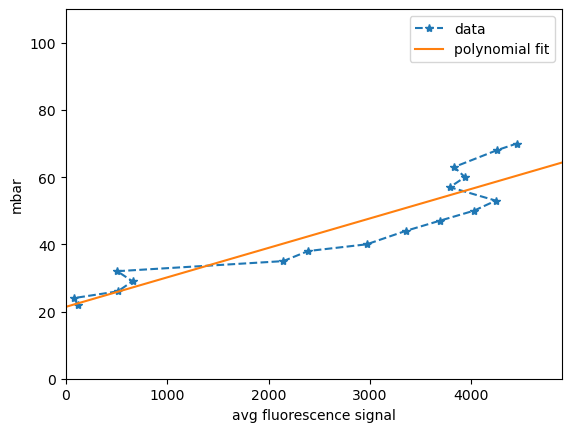

In [53]:
print(avg_sigs)

plt.plot(avg_sigs,pressures, '--*',label='data')
plt.ylabel('mbar')
plt.xlabel('avg fluorescence signal')

plt.xlim(0,1.1*max(avg_sigs))

mbar_per_sig = np.dot(avg_sigs,pressures) / np.dot(avg_sigs,avg_sigs)

xfit = np.linspace(0,1.1*max(avg_sigs),100)
yfit = mbar_per_sig*xfit

coeffs = np.polyfit(avg_sigs,pressures,1)
poly_func = np.poly1d(coeffs)


#plt.plot(xfit,yfit,label='fit')
plt.plot(xfit,poly_func(xfit),label='polynomial fit')
plt.ylim(0,110)

plt.legend()

AttributeError: 'NoneType' object has no attribute 'astype'

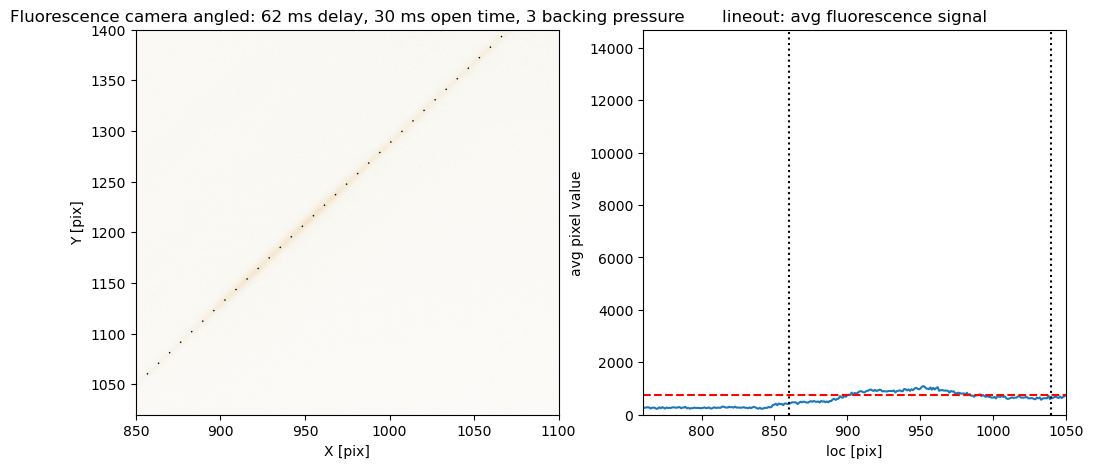

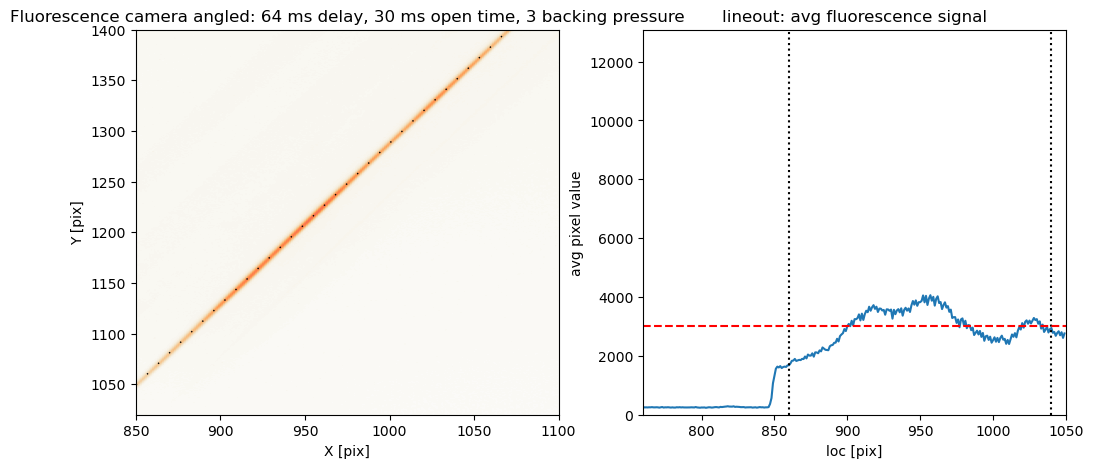

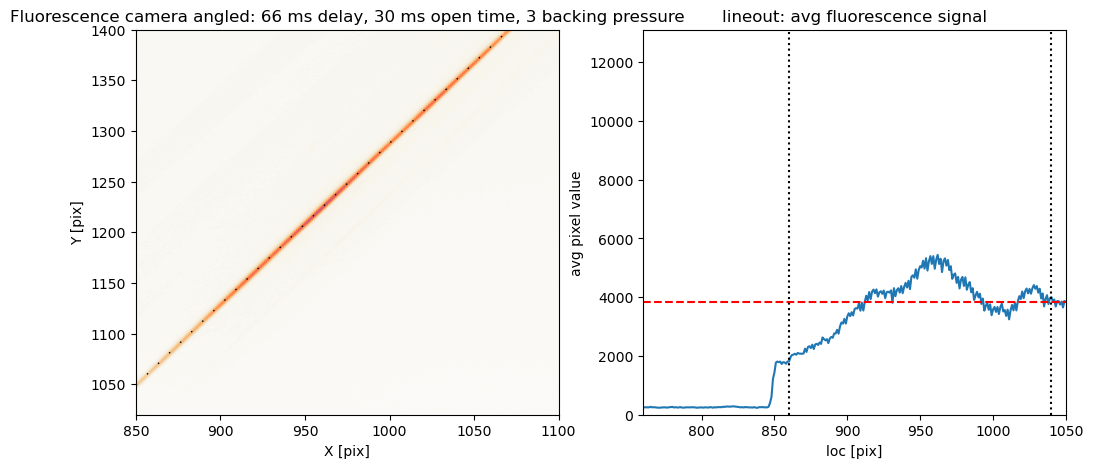

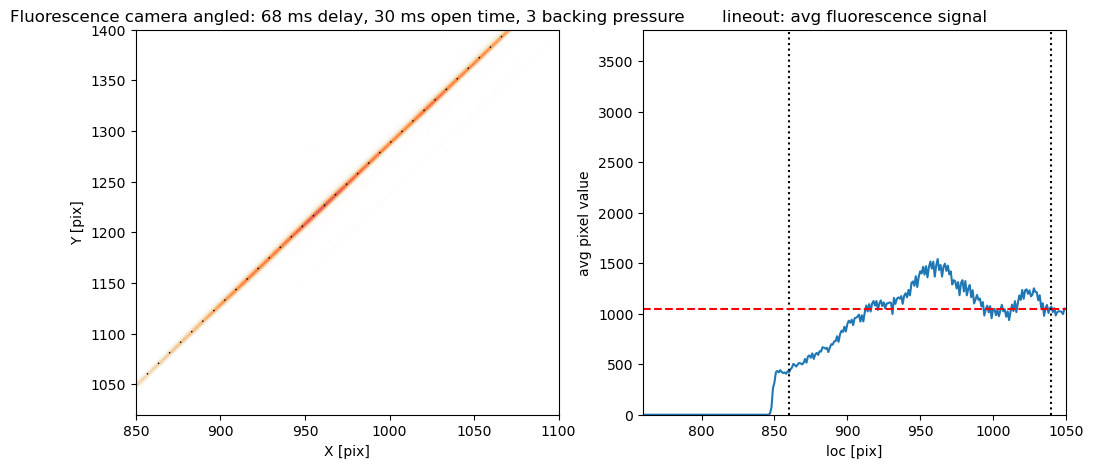

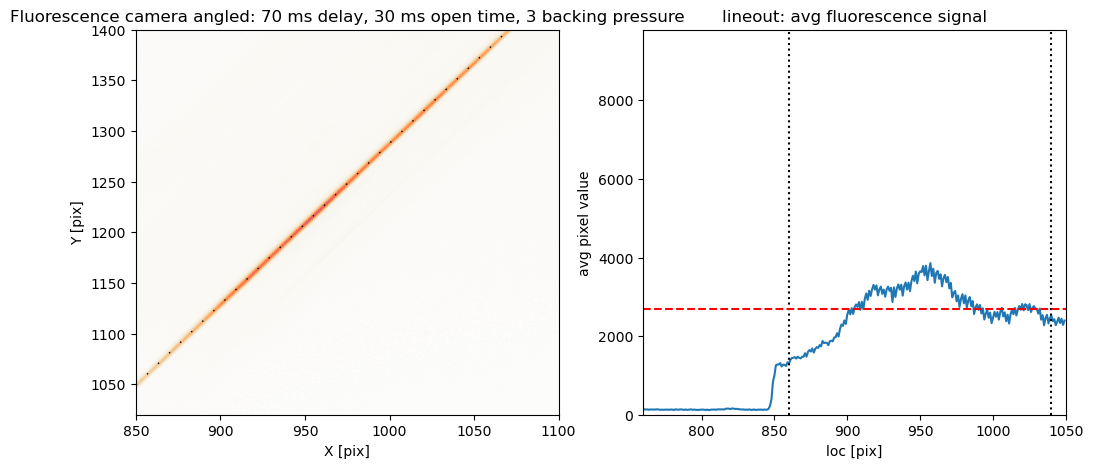

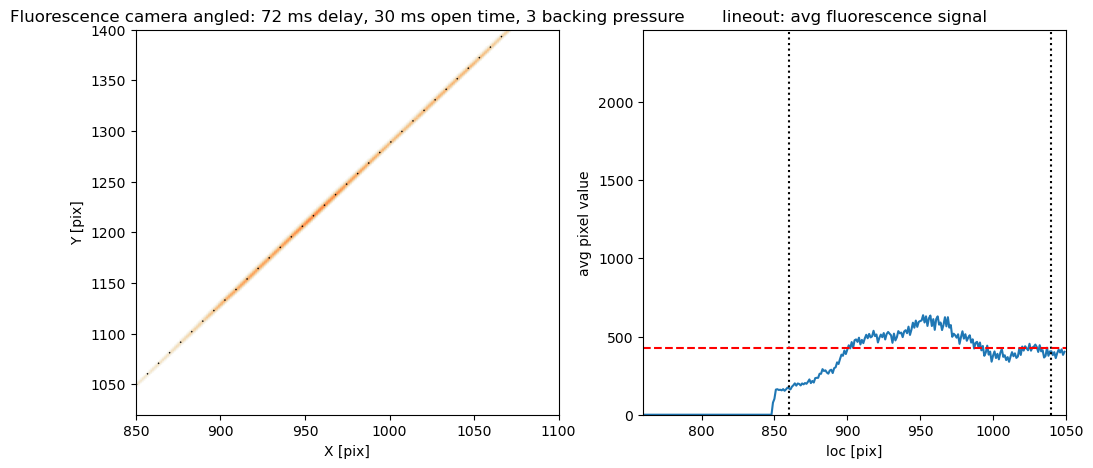

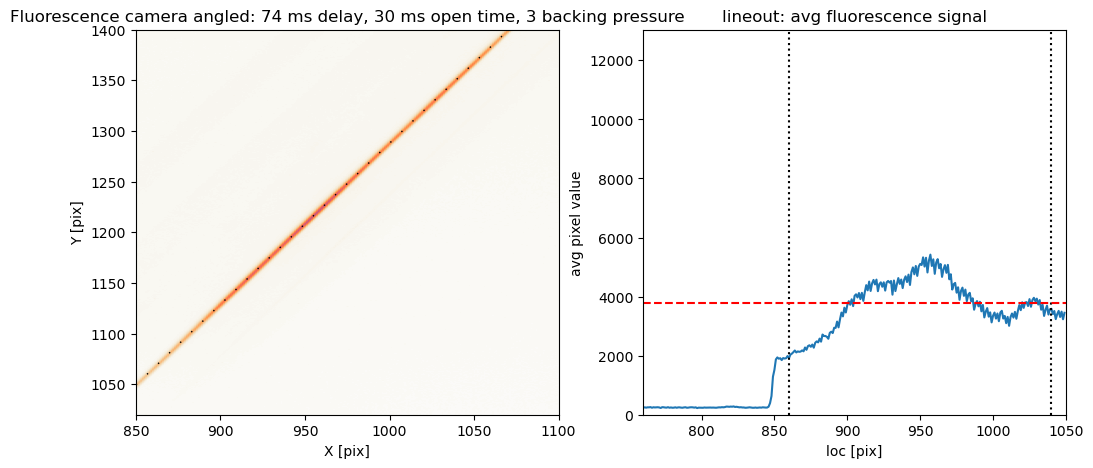

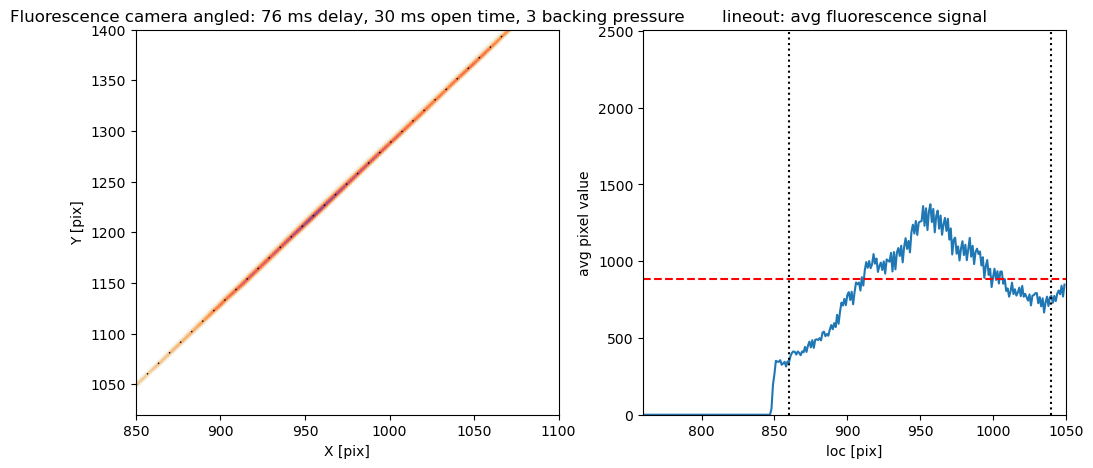

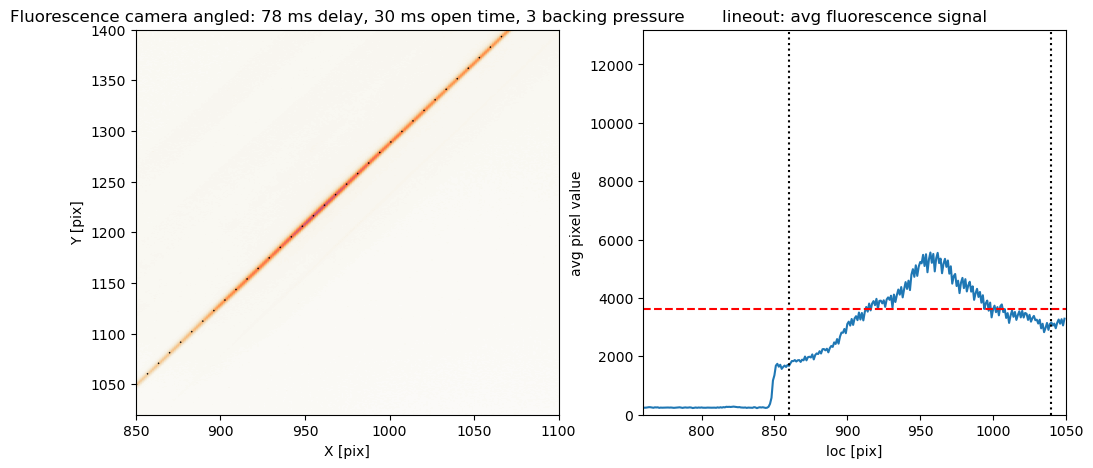

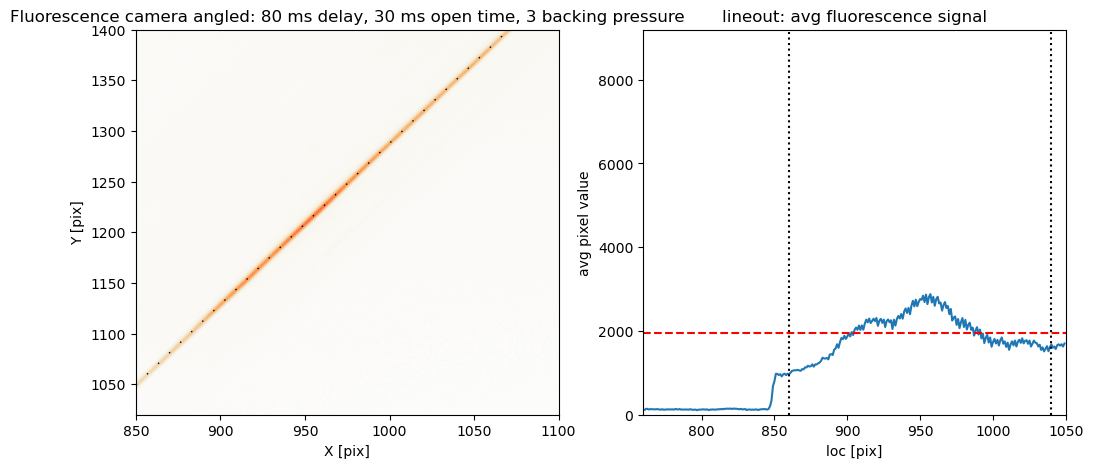

In [55]:
iota_delays = [62,64,66,68,70,72,74,76,78,80,81,82,84,86,88]
iota_open_ms = [30] #opening times of the iota gas jet [ms]
iota_BPs = [3,6]

results_cube = np.zeros((len(iota_delays), len(iota_open_ms), len(iota_BPs))) #create an empty 3D array which will contain the data


for iota_delay,i in zip(iota_delays,range(len(iota_delays))):
    for iota_open_time, j in zip(iota_open_ms, range(len(iota_open_ms))):
        for iota_BP, k in zip(iota_BPs, range(len(iota_BPs))):
            shotlist = glob.glob(common_folder_path + '/' +str(iota_BP) +'barBP/jet' + str (iota_open_time)+ "ms/" +str(iota_delay) + r"msdel/*tif*")
            p=iota_delays.index(iota_delay)
            q=iota_open_ms.index(iota_open_time)
            r=iota_BPs.index(iota_BP)
            
            results_cube[p,q,r] = get_avg_signal_angled(shotlist, bg_shotlist,
                                                        plot_flag=True,
                                                        title=str(iota_delay) + " ms delay, " + str(iota_open_time) + " ms open time, " + str(iota_BP)+ " backing pressure",
                                                        max_pixel_value="auto",
                                                        average_start_x=860,
                                                        average_stop_x=1040)

21.396730454054275
54.95068028019337


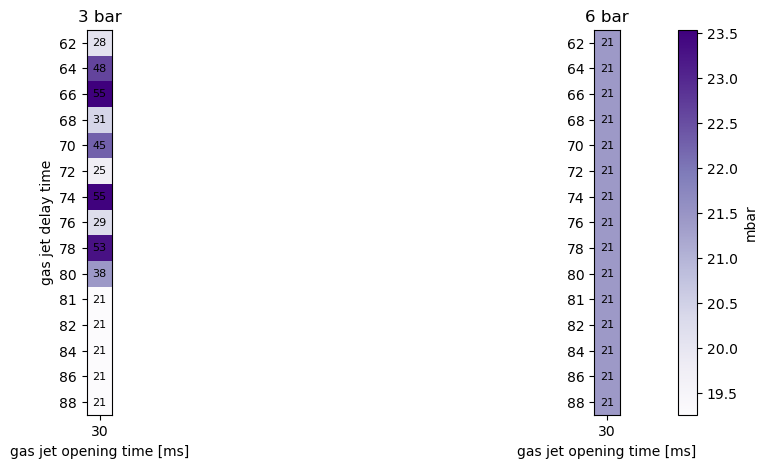

In [56]:
# Create a sample 3D array of values
array_3d = np.vectorize(poly_func)(results_cube)
array_3d=array_3d.clip(min=0)

min_value = np.min(array_3d)
max_value = np.max(array_3d)

print(min_value)
print(max_value)

# Create subplots for each 2D slice
fig, axs = plt.subplots(1, array_3d.shape[2], figsize=(15, 5))  # Adjust figsize as needed

cmap = "Purples"
# Plot each 2D slice
for i in range(array_3d.shape[2]):
    axs[i].imshow(array_3d[:, :, i], cmap=cmap, vmin=min_value, vmax=max_value)  # You can use any colormap you prefer
    axs[i].set_title(f"{iota_BPs[i]} bar")
    #axs[i].axis('off')  # Hide axis labels

    # Add text annotations
    for y in range(array_3d.shape[0]):
        for x in range(array_3d.shape[1]):
            if array_3d[y, x, i] > 0.1:
                axs[i].text(x, y, f'{array_3d[y, x, i]:.0f}', color='black', ha='center', va='center',fontsize=8)
    

    axs[i].set_xticks(np.arange(array_3d.shape[1]))
    axs[i].set_xticklabels(iota_open_ms)
    axs[i].set_yticks(np.arange(array_3d.shape[0]))
    axs[i].set_yticklabels(iota_delays)

    axs[i].set_xlabel('gas jet opening time [ms]')

axs[0].set_ylabel('gas jet delay time')

# Add color bar
cbar = fig.colorbar(axs[-1].imshow(array_3d[:, :, -1], cmap=cmap), ax=axs.ravel().tolist())
cbar.set_label('mbar')
